<a href="https://colab.research.google.com/github/attiaAR/ML-based-WAF/blob/master/waf_all_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn
import string
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
#from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier


import sklearn.gaussian_process.kernels as kernels

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy.stats import expon

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
payloads = pd.read_csv("/content/drive/MyDrive/csv/payloads.csv",index_col='index')
sql_keywords = pd.read_csv('/content/drive/MyDrive/csv/SQLKeywords.txt', index_col=False)
js_keywords = pd.read_csv('/content/drive/MyDrive/csv/JavascriptKeywords.txt', index_col=False)


In [5]:
payloads

,payload,is_malicious,injection_type
index,,,
0,dehumidify,1,LEGAL
1,Torie,1,LEGAL
2,befriended,1,LEGAL
3,Valdelarco,1,LEGAL
4,harvests,1,LEGAL
...,...,...,...
112152,TRaNSCRiTo,1,LEGAL
112153,ping.kasatsu%40asdn.cl,1,LEGAL
112154,exhaling,1,LEGAL


In [6]:
def create_feature_length(payloads):

    payloads['length'] = [len(str(row)) for row in payloads['payload']]
    return payloads
	
def create_feature_non_printable_characters(payloads):  
   
    payloads['non-printable'] = [ len([1 for letter in str(row) if letter not in string.printable]) for row in payloads['payload']]
    return payloads

def create_feature_punctuation_characters(payloads):
    
    payloads['punctuation'] = [ len([1 for letter in str(row) if letter in string.punctuation]) for row in payloads['payload']]
    return payloads
def create_feature_min_byte_value(payloads):

    payloads['min-byte'] = [ min(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

def create_feature_max_byte_value(payloads):

    payloads['max-byte'] = [ max(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

def create_feature_mean_byte_value(payloads):

    payloads['mean-byte'] = [ np.mean(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads
def create_feature_std_byte_value(payloads):

    payloads['std-byte'] = [ np.std(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads
def create_feature_distinct_bytes(payloads):

    payloads['distinct-bytes'] = [ len(list(set(bytearray(str(row), 'utf8')))) for row in payloads['payload']]
    return payloads
def create_feature_sql_keywords(payloads):
    
    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads

def create_feature_javascript_keywords(payloads):

    payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads

def create_feature_special_words(payloads):
    special_words = ["<>","../","alert","exec","password","<","’","alter","from","path/child","<!–","\"","and",
                 "href","script","=","(","bash_history","#include","select",">",")","between","insert",
                 "shell","|","$","/c","into","table","||","*","cmd","javascript:","union","-","*/","cn=",
                 "mail=","upper","–>","&","commit","objectclass","url=",";","+","count","onmouseover",
                 "User-Agent:",":","%00","-craw","or","where","/","%0a","document.cookie","order","winnt",
                 "/*","Accept:","etc/passwd","passw"]
    special_words = sorted(special_words, key=len, reverse=True)
    for wrd in special_words:
            payloads[wrd] = [int(row.count(wrd)) for row in payloads['payload']]
    return payloads


def create_features2(payloads):
    features = create_feature_length(payloads)
    features = create_feature_non_printable_characters(features)
    features = create_feature_punctuation_characters(features)
    features = create_feature_max_byte_value(features)
    features = create_feature_min_byte_value(features)
    features = create_feature_mean_byte_value(features)
    features = create_feature_std_byte_value(features)
    features = create_feature_distinct_bytes(features)
    features = create_feature_sql_keywords(features)
    features = create_feature_javascript_keywords(features)
    features = create_feature_special_words(features)
    del features['payload']

    return features


In [7]:
d = {}
for index,cat in enumerate(list(payloads['injection_type'].value_counts().keys())):
    d[cat] = index  
payloads['injection_type'].replace(d,inplace=True)
payloads

,payload,is_malicious,injection_type
index,,,
0,dehumidify,1,0
1,Torie,1,0
2,befriended,1,0
3,Valdelarco,1,0
4,harvests,1,0
...,...,...,...
112152,TRaNSCRiTo,1,0
112153,ping.kasatsu%40asdn.cl,1,0
112154,exhaling,1,0


In [8]:
Y = payloads['injection_type']
X = create_features2(pd.DataFrame(payloads['payload'].copy()))

In [9]:
X.head()

,length,non-printable,punctuation,max-byte,min-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords,...,),|,$,*,-,&,;,+,:,/
index,,,,,,,,,,,,,,,,,,,,,
0,10,0,0,121,100,106.4,6.873136,8,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,114,84,103.0,10.526158,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,114,98,103.2,4.791659,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,0,0,114,86,102.1,7.854298,8,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,118,97,110.0,7.516648,7,0,0,...,0,0,0,0,0,0,0,0,0,0


[1.95116964e+06 1.00091378e+04 1.42754549e+06 1.34545284e+04
 2.42789413e+05 2.68640034e+04 2.18548692e+05 3.21893651e+05
 4.84268997e+04 5.52132687e+04 4.68666404e+03            nan
 2.32725639e+04 1.81914629e+02 2.44844190e+03            nan
            nan 5.35166021e+03 6.23019203e+02 1.23658682e+01
 2.79636834e+01            nan 7.77474820e+04 7.96050526e+03
 5.27924981e+01 1.75075425e+00 6.24818638e+04 4.90211190e+00
 1.99325985e+03 1.39903585e+03 2.39035818e+03 7.53857355e+01
 8.17018650e-01 1.48307485e+02            nan 5.33520869e+02
 1.14627251e+02 4.83347337e+01 3.51375199e+03 1.40137765e+03
 4.14803257e+03 7.23319293e+03 2.52848912e+01 8.16147301e+02
 5.54807404e+04 1.23658682e+01 8.23038733e+02 5.85192501e+03
 1.23658682e+01 2.45896992e+03 1.13320149e+03 3.42977885e+02
 4.57835150e+03 8.93002775e+03 4.70796948e+03 2.47317364e+01
 5.18686510e+03 9.13183592e+03 1.77678893e+05 1.02641875e+03
 1.64067541e+05 1.44549968e+05 1.14091993e+05 1.98453994e+05
 1.22716887e+05 1.472272

['upper',
 'commit',
 'alter',
 'cn=',
 '<!–',
 '#include',
 '–>',
 'into',
 'between',
 'winnt',
 'insert',
 'mail=',
 'order',
 'count',
 'objectclass',
 '<>',
 'where',
 'password',
 'url=',
 'and',
 '’',
 '+',
 '%0a',
 'table',
 'exec',
 'shell',
 'union',
 'onmouseover',
 '%00',
 'passw',
 'from',
 '/c',
 'document.cookie',
 '*/',
 'or',
 'etc/passwd',
 'cmd',
 '$',
 'href',
 'select',
 '||',
 '/*',
 'non-printable',
 'max-byte',
 '|',
 '*',
 '-',
 'javascript:',
 'mean-byte',
 'sql-keywords',
 'js-keywords',
 '../',
 'alert',
 ':',
 'script',
 '(',
 ')',
 '&',
 ';',
 '=',
 '"',
 '<',
 '>',
 'std-byte',
 'min-byte',
 '/',
 'distinct-bytes',
 'punctuation',
 'length',
 'Accept:',
 'path/child',
 'User-Agent:',
 'bash_history',
 '-craw']

['document.cookie 0.8170186496201373',
 'shell 1.7507542491860084',
 'onmouseover 4.9021118977208245',
 'mean-byte 12.365868192110593',
 '* 12.365868192110593',
 'and 12.365868192110593',
 '( 24.731736384221186',
 'non-printable 25.284891153872813',
 '’ 27.963683381924632',
 '$ 48.33473371103875',
 'exec 52.79249813476526',
 '/c 75.38573550104968',
 'cmd 114.62725056739919',
 '*/ 148.30748509477968',
 'count 181.91462909241605',
 '../ 342.9778848426381',
 'etc/passwd 533.5208685997728',
 'url= 623.0192032762155',
 'max-byte 816.1473006792994',
 '- 823.0387328455955',
 '= 1026.4187535315498',
 'User-Agent: 1051.3755798668076',
 'js-keywords 1133.201491932281',
 'passw 1399.0358524196904',
 'select 1401.377654150912',
 '%00 1993.259850982041',
 'from 2390.3581838609616',
 'objectclass 2448.441902037898',
 'sql-keywords 2458.969920081147',
 'href 3513.7519900781626',
 '|| 4148.032568600137',
 'alert 4578.351495476413',
 'insert 4686.664044809916',
 'script 4707.969484656444',
 ') 5186.865

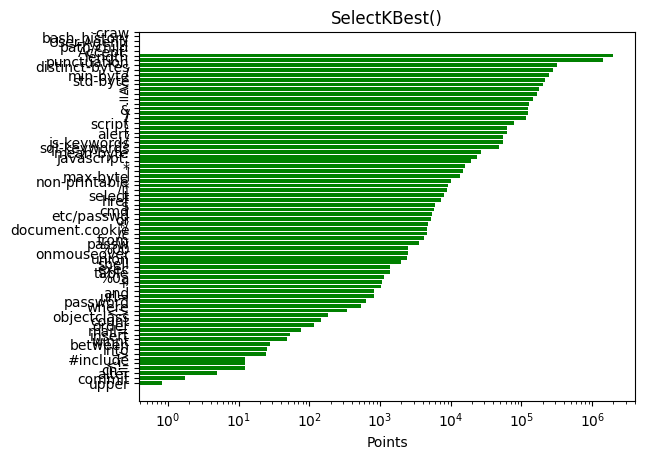

In [10]:
test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X, Y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
# summarize scores
np.set_printoptions(precision=2)
print(fit.scores_)

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)

# To get your top 10 feature names
featuress = []
for i in range(74):
    featuress.append(X.columns[indices[i]])

display(featuress)
display([featuress[i] + ' ' + str(fit.scores_[i]) for i in indices[range(74)]])


plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(featuress))
performance = 3 + 10 * np.random.rand(len(featuress))
error = np.random.rand(len(featuress))

ax.barh(y_pos, fit.scores_[indices[range(74)]],  align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(featuress)
ax.set_xscale('log')

#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Points')
ax.set_title('SelectKBest()')

plt.show()

In [11]:
def get1Grams(payload_obj):
    '''Divides a string into 1-grams
    
    Example: input - payload: "<script>"
             output- ["<","s","c","r","i","p","t",">"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)

In [12]:
def get2Grams(payload_obj):
    '''Divides a string into 2-grams
    
    Example: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

tfidf_vectorizer_2grams = TfidfVectorizer(tokenizer=get2Grams)
count_vectorizer_2grams = CountVectorizer(min_df=1, tokenizer=get2Grams)

In [13]:
def get3Grams(payload_obj):
    '''Divides a string into 3-grams
    
    Example: input - payload: "<script>"
             output- ["<sc","scr","cri","rip","ipt","pt>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-3):
        ngrams.append(payload[i:i+3])
    return ngrams

tfidf_vectorizer_3grams = TfidfVectorizer(tokenizer=get3Grams)
count_vectorizer_3grams = CountVectorizer(min_df=1, tokenizer=get3Grams)

In [14]:
def visualize_feature_space_by_projection(X,Y,title='PCA'):
    '''Plot a two-dimensional projection of the dataset in the specified feature space
    
    input: X - data
           Y - labels
           title - title of plot
    '''
    pca = TruncatedSVD(n_components=2)
    X_r = pca.fit(X).transform(X)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['blue', 'darkorange','yellow']
    lw = 2

    #Plot malicious and non-malicious separately with different colors
    for color, i, y in zip(colors, [0, 1], Y):
        plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.3, lw=lw,
                    label=i)
        
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()


explained variance ratio (first two components): [0.37 0.15]


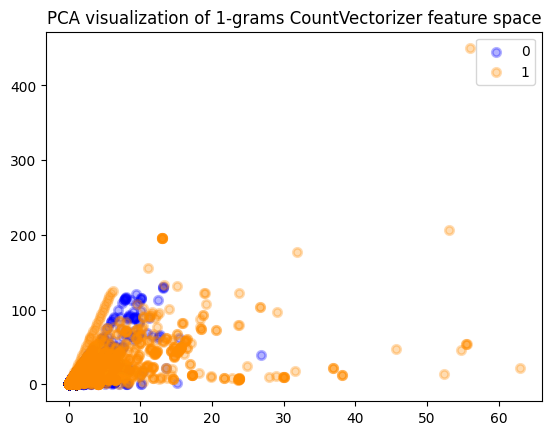

In [15]:
X = count_vectorizer_1grams.fit_transform(payloads['payload'])
Y = payloads['injection_type']
visualize_feature_space_by_projection(X,Y,title='PCA visualization of 1-grams CountVectorizer feature space')

explained variance ratio (first two components): [0.01 0.  ]


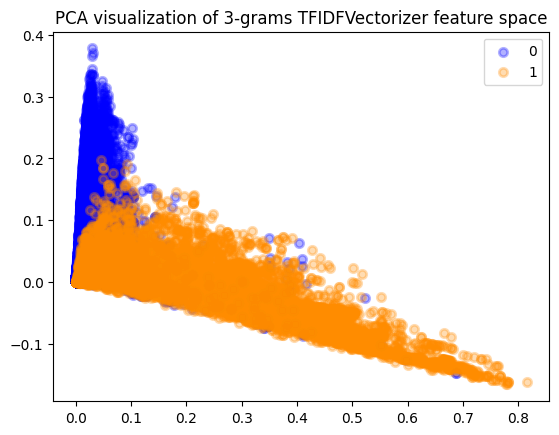

In [16]:


X = tfidf_vectorizer_3grams.fit_transform(payloads['payload'])
Y = payloads['injection_type']
visualize_feature_space_by_projection(X,Y,title='PCA visualization of 3-grams TFIDFVectorizer feature space')



explained variance ratio (first two components): [0.29 0.52]


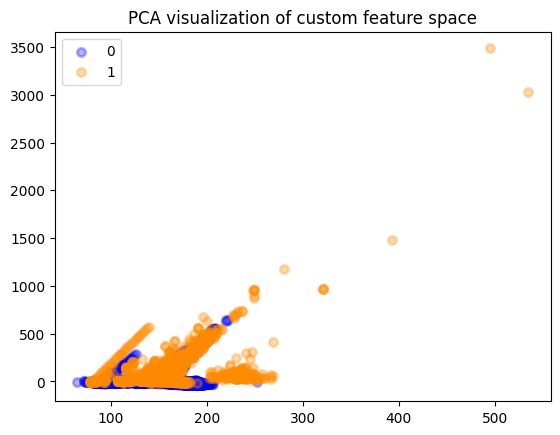

In [17]:
X = create_features2(pd.DataFrame(payloads['payload'].copy()))
Y = payloads['injection_type']
visualize_feature_space_by_projection(X,Y,title='PCA visualization of custom feature space')

In [18]:
def train_model(clf, param_grid, X, Y):
    '''Trains and evaluates the model clf from input
    
    The function selects the best model of clf by optimizing for the validation data,
    then evaluates its performance using the out of sample test data.
    
    input - clf: the model to train
            param_grid: a dict of hyperparameters to use for optimization
            X: features
            Y: labels
    
    output - the best estimator (trained model)
             the confusion matrix from classifying the test data
    '''
    
    #First, partition into train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    n_iter = 5
    #If number of possible iterations are less than prefered number of iterations, 
    #set it to the number of possible iterations
    #number of possible iterations are not less than prefered number of iterations if any argument is expon()
    #because expon() is continous (writing 100 instead, could be any large number)
    n_iter = min(n_iter,np.prod([
        100 if type(xs) == type(expon()) 
        else len(xs) 
        for xs in param_grid.values()
    ]))
    
    #perform a grid search for the best parameters on the training data.
    #Cross validation is made to select the parameters, so the training data is actually split into
    #a new train data set and a validation data set, K number of times
    from sklearn.model_selection import ShuffleSplit
  
    cv = ShuffleSplit(n_splits=1,  test_size=0.2, random_state=0) #DEBUG: n_iter=10
    #cv = ShuffleSplit(n=len(X_train), n_iter=5, test_size=0.2, random_state=0) #DEBUG: n_iter=10
    #cv = KFold(n=len(X), n_folds=10)
    random_grid_search = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid,
        cv=cv, 
        scoring=['f1_macro','precision_macro'],  #scoring='f1', 
        n_iter=1,#n_iter, #DEBUG 1   =5
        random_state=5,
         refit = 'f1_macro', #refit=True,
        verbose=10
    )
    
    '''Randomized search used instead. We have limited computing power
    grid_search = GridSearchCV(
        clf,
        param_grid=param_grid,
        cv=cv,
        scoring='f1', #accuracy/f1/f1_weighted all give same result?
        verbose=10,
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)
    '''
    display("00000000")
    random_grid_search.fit(X_train, Y_train)
    
    #Evaluate the best model on the test data
    display("11111111111111111")
    Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)
    display("2222222222222")
    display(random_grid_search.best_estimator_.predict_proba(X_test)[:, 1])
    display("2222222222222")
    display(  random_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  )
    display("2222222222222")
    Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)[:, 1] #1]
    display("333333333333333")

    confusion = confusion_matrix(Y_test, Y_test_predicted)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    #Calculate recall (sensitivity) from confusion matrix
    sensitivity = TP / float(TP + FN)
    
    #Calculate specificity from confusion matrix
    specificity = TN / float(TN + FP)

    #Calculate accuracy
    accuracy = (confusion[0][0] + confusion[1][1]) / (confusion.sum().sum())
    display("44444444444444444")
    #Calculate axes of ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predicted_prob , pos_label=5)
    display("5555555555555555555")
    #Area under the ROC curve
    display("6666666666666666")
    Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)
    auc = roc_auc_score(Y_test, Y_test_predicted_prob, multi_class="ovo")
    display("777777777777777")

    return {
        'conf_matrix':confusion, 
        'accuracy':accuracy, 
        'sensitivity':sensitivity,
        'specificity':specificity,
        'auc':auc,
        'params':random_grid_search.best_params_,
        'model':random_grid_search.best_estimator_,
        'roc':{'fpr':fpr,'tpr':tpr,'thresholds':thresholds}
    }

In [19]:
def create_classifier_inputs_using_vectorizers(vectorizer, subscript):
    '''make pipelines of the specified vectorizer with the classifiers to train
    
    input - vectorizer: the vectorizer to add to the pipelines
            subscript:  subscript name for the dictionary key
            
    output - A dict of inputs to use for train_model(); a pipeline and a dict of params to optimize
    '''
    
    classifier_inputs = {}
    
    classifier_inputs[subscript + ' MLPClassifier'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=False,
            verbose=True
            
        ))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__hidden_layer_sizes':[(500,250,125,62)],
            'clf__alpha':[0.0005,0.001,0.01,0.1,1],
            'clf__learning_rate':['constant','invscaling'],
            'clf__learning_rate_init':[0.001,0.01,0.1,1],
            'clf__momentum':[0,0.9],
        }
    }
    '''
    classifier_inputs[subscript + ' MultinomialNB'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',MultinomialNB())]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40]
        }
    }
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__n_estimators':[10,20,40,60]
        }
    }
    classifier_inputs[subscript + ' Logistic'] = {
        'pipeline':Pipeline([('vect', vectorizer), ('clf',LogisticRegression())]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
    classifier_inputs[subscript + ' SVM'] = {
        'pipeline':Pipeline([('vect', vectorizer), ('clf',SVC(probability=True))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__gamma':[0.001, 0.0001,'auto'],
            'clf__kernel':['rbf']
        }
    }
    '''
    
    return classifier_inputs

In [20]:
def create_classifier_inputs(subscript):
    
    classifier_inputs = {}
    
    
    '''classifier_inputs[subscript + ' GPC'] = {
        'pipeline':GaussianProcessClassifier(),
        'dict_params': {
            'kernel':[
                1.0*kernels.RBF(1.0),
                1.0*kernels.Matern(),
                1.0*kernels.RationalQuadratic(),
                1.0*kernels.DotProduct()
            ]
        }
    }'''
    classifier_inputs[subscript + ' AdaBoostClassifier'] = {
        'pipeline':AdaBoostClassifier(n_estimators=100),
        'dict_params': {
            'n_estimators':[10,20,50, 100], 
            'learning_rate':[0.1, 0.5, 1.0, 2.0]
        }
    }
    classifier_inputs[subscript + ' SGD'] = {
        'pipeline':SGDClassifier(loss="log", penalty="l2"),
        'dict_params': {
            'learning_rate': ['optimal']
        }
    }
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0),
        'dict_params': {
            'n_estimators':[10,20,40,60]
        }
    }
    classifier_inputs[subscript + ' DecisionTree'] = {
        'pipeline':  DecisionTreeClassifier(max_depth=5),
        'dict_params': {
            'min_samples_split': [2]
        }
    }
    '''classifier_inputs[subscript + ' MLPClassifier'] = {
        'pipeline':MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=False,
            verbose=True
            
        ),
        'dict_params': {
            'hidden_layer_sizes':[(300, 200, 150, 150), (30, 30, 30), (150, 30, 30, 150), 
                                  (400, 250, 100, 100) , (150, 200, 300)],
            'alpha':[0.0005,0.001,0.01,0.1,1],
            'learning_rate':['constant','invscaling'],
            'learning_rate_init':[0.0005,0.001,0.01,0.1,1],
            'momentum':[0,0.9],
        }
    }'''
    classifier_inputs[subscript + ' Logistic'] = {
        'pipeline':LogisticRegression(),
        'dict_params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
    classifier_inputs[subscript + ' MultinomialNB'] = {
        'pipeline':MultinomialNB(),
        'dict_params': {
            'alpha': [1.0]
        }
    }
    
    '''classifier_inputs[subscript + ' SVM'] = {
        'pipeline':SVC(probability=True),
        'dict_params': {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'gamma':[0.001, 0.0001,'auto'],
            'kernel':['rbf']
        }
    }'''
    return classifier_inputs

In [21]:
classifier_results = pd.DataFrame(columns=['accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc'])#,index=classifier_inputs.keys())

In [ ]:
classifier_inputs = {}
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_1grams,'count 1grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_2grams,'count 2grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_3grams,'count 3grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_1grams,'tfidf 1grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_2grams,'tfidf 2grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_3grams,'tfidf 3grams'))


X = payloads['payload'] 
Y = payloads['injection_type']

for classifier_name, inputs in classifier_inputs.items():
    display(inputs['dict_params'])
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

{'clf__alpha': [0.0005, 0.001, 0.01, 0.1, 1],
 'clf__hidden_layer_sizes': [(500, 250, 125, 62)],
 'clf__learning_rate': ['constant', 'invscaling'],
 'clf__learning_rate_init': [0.001, 0.01, 0.1, 1],
 'clf__momentum': [0, 0.9],
 'vect__min_df': [1, 2, 5, 10, 20, 40]}

'00000000'

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1; 1/1] START clf__alpha=0.1, clf__hidden_layer_sizes=(500, 250, 125, 62), clf__learning_rate=invscaling, clf__learning_rate_init=0.01, clf__momentum=0.9, vect__min_df=2
Iteration 1, loss = 0.19477856
Iteration 2, loss = 0.13820346
Iteration 3, loss = 0.12420025
Iteration 4, loss = 0.11244749
Iteration 5, loss = 0.08955424
Iteration 6, loss = 0.09100714
Iteration 7, loss = 0.08138149
Iteration 8, loss = 0.07129213
Iteration 9, loss = 0.07498647
Iteration 10, loss = 0.07948652
Iteration 11, loss = 0.07009314
Iteration 12, loss = 0.06615018
Iteration 13, loss = 0.06761727
Iteration 14, loss = 0.06535254
Iteration 15, loss = 0.06898740
Iteration 16, loss = 0.07116253
Iteration 17, loss = 0.06498779
Iteration 18, loss = 0.06101962
Iteration 19, loss = 0.06269323
Iteration 20, loss = 0.06182264
Iteration 21, loss = 0.06121270
Iteration 22, loss = 0.06263392
Iteration 23, loss = 0.06135196
Iteration 24, loss = 0.06494075
Iterat

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/1; 1/1] END clf__alpha=0.1, clf__hidden_layer_sizes=(500, 250, 125, 62), clf__learning_rate=invscaling, clf__learning_rate_init=0.01, clf__momentum=0.9, vect__min_df=2; f1_macro: (test=0.713) precision_macro: (test=0.726) total time= 3.6min
Iteration 1, loss = 0.18180187
Iteration 2, loss = 0.13432371
Iteration 3, loss = 0.12073379
Iteration 4, loss = 0.11695264
Iteration 5, loss = 0.09411748
Iteration 6, loss = 0.08318165
Iteration 7, loss = 0.08166459
Iteration 8, loss = 0.07659266
Iteration 9, loss = 0.07015476
Iteration 10, loss = 0.07118360
Iteration 11, loss = 0.06941646
Iteration 12, loss = 0.06479187
Iteration 13, loss = 0.06423677
Iteration 14, loss = 0.07950920
Iteration 15, loss = 0.07577331
Iteration 16, loss = 0.06945742
Iteration 17, loss = 0.06366235
Iteration 18, loss = 0.06238573
Iteration 19, loss = 0.06312924
Iteration 20, loss = 0.06164075
Iteration 21, loss = 0.06281727
Iteration 22, loss = 0.06295170
Iteration 23, loss = 0.06449289
Iteration 24, loss = 0.063

'11111111111111111'

'2222222222222'

array([1.78e-03, 7.43e-04, 5.56e-03, ..., 1.06e-03, 1.10e-03, 9.78e-01])

'2222222222222'

array([1.78e-03, 7.43e-04, 5.56e-03, ..., 1.06e-03, 1.10e-03, 9.78e-01])

'2222222222222'

'333333333333333'

'44444444444444444'

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


'5555555555555555555'

'6666666666666666'

'777777777777777'

{'clf__alpha': [0.0005, 0.001, 0.01, 0.1, 1],
 'clf__hidden_layer_sizes': [(500, 250, 125, 62)],
 'clf__learning_rate': ['constant', 'invscaling'],
 'clf__learning_rate_init': [0.001, 0.01, 0.1, 1],
 'clf__momentum': [0, 0.9],
 'vect__min_df': [1, 2, 5, 10, 20, 40]}

'00000000'

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1; 1/1] START clf__alpha=0.1, clf__hidden_layer_sizes=(500, 250, 125, 62), clf__learning_rate=invscaling, clf__learning_rate_init=0.01, clf__momentum=0.9, vect__min_df=2
Iteration 1, loss = 0.26881383
Iteration 2, loss = 0.21372463
Iteration 3, loss = 0.14935737
Iteration 4, loss = 0.12999891
Iteration 5, loss = 0.09725935
Iteration 6, loss = 0.11489367
Iteration 7, loss = 0.09366275
Iteration 8, loss = 0.07766060
Iteration 9, loss = 0.07927227
Iteration 10, loss = 0.07391594
Iteration 11, loss = 0.07315931
Iteration 12, loss = 0.07352937
Iteration 13, loss = 0.07247167
Iteration 14, loss = 0.07580394
Iteration 15, loss = 0.06915415
Iteration 16, loss = 0.07615459
Iteration 17, loss = 0.07679265
Iteration 18, loss = 0.06571660
Iteration 19, loss = 0.06429623
Iteration 20, loss = 0.06569945
Iteration 21, loss = 0.06635468
Iteration 22, loss = 0.06989956
Iteration 23, loss = 0.06542176
Iteration 24, loss = 0.06671436
Iterat

In [ ]:
classifier_inputs = {}
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_1grams,'count 1grams'))
#classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_2grams,'count 2grams'))
#classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_3grams,'count 3grams'))
#classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_1grams,'tfidf 1grams'))
#classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_2grams,'tfidf 2grams'))
#classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_3grams,'tfidf 3grams'))


X = payloads['payload']
Y = payloads['injection_type']
 
for classifier_name, inputs in classifier_inputs.items():
    display(inputs['dict_params'])
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        classifier_namee = classifier_name
        inputse = inputs

In [ ]:
        #result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        ########################################################################
#def train_model(clf, param_grid, X, Y):
clf = inputs['pipeline']
param_grid = inputs['dict_params']
#X Y
'''Trains and evaluates the model clf from input

The function selects the best model of clf by optimizing for the validation data,
then evaluates its performance using the out of sample test data.

input - clf: the model to train
        param_grid: a dict of hyperparameters to use for optimization
        X: features
        Y: labels

output - the best estimator (trained model)
        the confusion matrix from classifying the test data
'''

#First, partition into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_iter = 5
#If number of possible iterations are less than prefered number of iterations, 
#set it to the number of possible iterations
#number of possible iterations are not less than prefered number of iterations if any argument is expon()
#because expon() is continous (writing 100 instead, could be any large number)
n_iter = min(n_iter,np.prod([
    100 if type(xs) == type(expon()) 
    else len(xs) 
    for xs in param_grid.values()
]))

#perform a grid search for the best parameters on the training data.
#Cross validation is made to select the parameters, so the training data is actually split into
#a new train data set and a validation data set, K number of times
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=1,  test_size=0.2, random_state=0) #DEBUG: n_iter=10
#cv = ShuffleSplit(n=len(X_train), n_iter=5, test_size=0.2, random_state=0) #DEBUG: n_iter=10
#cv = KFold(n=len(X), n_folds=10)
random_grid_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_grid,
    cv=cv, 
    scoring=['f1_macro','precision_macro'],  #scoring='f1', 
    n_iter=1,#n_iter, #DEBUG 1   =5
    random_state=5,
    refit = 'f1_macro', #refit=True,
    verbose=10
)

'''Randomized search used instead. We have limited computing power
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1', #accuracy/f1/f1_weighted all give same result?
    verbose=10,
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)
'''
display("00000000")
random_grid_search.fit(X_train, Y_train)


In [ ]:

#Evaluate the best model on the test data
display("11111111111111111")
Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)
display("2222222222222")
display(random_grid_search.best_estimator_.predict_proba(X_test))
display("2222222222222")
display( random_grid_search.best_estimator_.predict_proba(X_test)[:, 1] )
display("2222222222222")
display( random_grid_search.best_estimator_.predict_proba(X_test)[:, 2] )
display("2222222222222")
Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)[:, 1] #1]
display("333333333333333")

confusion = confusion_matrix(Y_test, Y_test_predicted)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Calculate recall (sensitivity) from confusion matrix
sensitivity = TP / float(TP + FN)

#Calculate specificity from confusion matrix
specificity = TN / float(TN + FP)

#Calculate accuracy
accuracy = (confusion[0][0] + confusion[1][1]) / (confusion.sum().sum())
display("44444444444444444")
#Calculate axes of ROC curve


'11111111111111111'

'2222222222222'

array([[9.98e-01, 1.15e-03, 2.54e-04, 6.48e-04, 6.68e-05],
       [9.92e-01, 1.22e-03, 6.86e-04, 6.25e-03, 1.08e-04],
       [9.99e-01, 2.48e-04, 2.73e-04, 1.92e-04, 1.40e-05],
       ...,
       [9.99e-01, 9.62e-04, 8.01e-05, 2.01e-04, 2.71e-05],
       [9.99e-01, 6.74e-04, 1.52e-04, 6.04e-04, 4.06e-05],
       [1.40e-04, 9.73e-01, 2.20e-03, 1.16e-02, 1.34e-02]])

'2222222222222'

array([1.15e-03, 1.22e-03, 2.48e-04, ..., 9.62e-04, 6.74e-04, 9.73e-01])

'2222222222222'

array([2.54e-04, 6.86e-04, 2.73e-04, ..., 8.01e-05, 1.52e-04, 2.20e-03])

'2222222222222'

'333333333333333'

'44444444444444444'

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predicted_prob , pos_label=5)
display("5555555555555555555")
#Area under the ROC curve
display("6666666666666666")
auc = roc_auc_score(Y_test, random_grid_search.best_estimator_.predict_proba(X_test), multi_class="ovo")
display("777777777777777")

result_dict = {
    'conf_matrix':confusion, 
    'accuracy':accuracy, 
    'sensitivity':sensitivity,
    'specificity':specificity,
    'auc':auc,
    'params':random_grid_search.best_params_,
    'model':random_grid_search.best_estimator_,
    'roc':{'fpr':fpr,'tpr':tpr,'thresholds':thresholds}
}





      
        ########################################################################
classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


'5555555555555555555'

'6666666666666666'

'777777777777777'

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
count 1grams MLPClassifier,0.965494,0.979677,0.999551,0.967467,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."


In [ ]:
display(pd.DataFrame(payloads['payload'].copy()))

In [ ]:
classifier_inputs_custom = {}

#Get classifiers and parameters to optimize
classifier_inputs_custom.update(create_classifier_inputs('custom'))

#Extract payloads and labels
Y = payloads['injection_type']
X = create_features2(pd.DataFrame(payloads['payload'].copy()))

#Select the best features
X_new = SelectKBest(score_func=chi2, k=4).fit_transform(X,Y)

#Call train_model for every classifier and save results to classifier_results
for classifier_name, inputs in classifier_inputs_custom.items():
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

pickle.dump( classifier_results, open( "/content/drive/MyDrive/csv/pkl/trained_classifiers_custom_all_features.p", "wb" ) )

In [ ]:
pickle.dump( classifier_results, open( "/content/drive/MyDrive/csv/pkl/trained_classifiers_custom_all_features.p", "wb" ) )
#Save classifiers in a pickle file to be able to re-use them without re-training
pickle.dump( classifier_results, open( "/content/drive/MyDrive/csv/pkl/trained_classifiers.p", "wb" ) )

In [ ]:
#Display the results for the classifiers that were trained using our custom feature space
custom_features_classifiers = pickle.load( open("/content/drive/MyDrive/csv/pkl/trained_classifiers_custom_all_features.p", "rb"))
display(custom_features_classifiers)

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
count 1grams MLPClassifier,0.965494,0.979677,0.999551,0.967467,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."
custom AdaBoostClassifier,0.963845,0.957280,1.000000,0.882881,"[[20029, 0, 20, 2, 0], [71, 1591, 31, 1, 2], [...","{'n_estimators': 20, 'learning_rate': 0.5}","(DecisionTreeClassifier(max_depth=1, random_st...","{'fpr': [0.0, 0.00013374348000534973, 0.000401..."
custom SGD,0.955820,0.938892,1.000000,0.919740,"[[19965, 0, 85, 1, 0], [96, 1475, 108, 16, 1],...",{'learning_rate': 'optimal'},SGDClassifier(loss='log'),"{'fpr': [0.0, 0.037715661361508626, 0.03860728..."
custom RandomForest,0.967277,0.983967,0.999950,0.968158,"[[20040, 1, 3, 7, 0], [27, 1657, 4, 6, 2], [10...",{'n_estimators': 10},"(DecisionTreeClassifier(max_features='auto', r...","{'fpr': [0.0, 0.06125451384245018, 0.067986269..."
custom DecisionTree,0.959253,0.958461,0.999749,0.869469,"[[19948, 5, 98, 0, 0], [68, 1569, 52, 6, 1], [...",{'min_samples_split': 2},DecisionTreeClassifier(max_depth=5),"{'fpr': [0.0, 0.004101466720164058, 0.05514689..."
custom Logistic,0.960234,0.917221,0.999601,0.823563,"[[20021, 8, 14, 8, 0], [137, 1518, 37, 4, 0], ...",{'C': 1000},LogisticRegression(C=1000),"{'fpr': [0.0, 4.4581160001783245e-05, 0.000936..."
custom MultinomialNB,0.852481,0.963875,0.999332,0.894996,"[[17948, 12, 769, 1270, 52], [44, 1174, 57, 31...",{'alpha': 1.0},MultinomialNB(),"{'fpr': [0.0, 0.0020953145200838124, 0.0025857..."


In [ ]:
#Display the results for the classifiers that were using bag of words feature spaces
classifier_results = pickle.load( open( "/content/drive/MyDrive/csv/pkl/trained_classifiers.p", "rb" ) )
display(classifier_results)

,F1-score,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
custom RandomForest,0.9993,0.9673,0.9840,1.0000,0.9682,"[[20040, 1, 3, 7, 0], [27, 1657, 4, 6, 2], [10...",{'n_estimators': 10},"(DecisionTreeClassifier(max_features='auto', r...","{'fpr': [0.0, 0.06125451384245018, 0.067986269..."
count 1grams MLPClassifier,0.9989,0.9655,0.9797,0.9996,0.9675,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."
custom MultinomialNB,0.9984,0.8525,0.9639,0.9993,0.8950,"[[17948, 12, 769, 1270, 52], [44, 1174, 57, 31...",{'alpha': 1.0},MultinomialNB(),"{'fpr': [0.0, 0.0020953145200838124, 0.0025857..."
custom AdaBoostClassifier,0.9982,0.9638,0.9573,1.0000,0.8829,"[[20029, 0, 20, 2, 0], [71, 1591, 31, 1, 2], [...","{'n_estimators': 20, 'learning_rate': 0.5}","(DecisionTreeClassifier(max_depth=1, random_st...","{'fpr': [0.0, 0.00013374348000534973, 0.000401..."
custom DecisionTree,0.9982,0.9593,0.9585,0.9997,0.8695,"[[19948, 5, 98, 0, 0], [68, 1569, 52, 6, 1], [...",{'min_samples_split': 2},DecisionTreeClassifier(max_depth=5),"{'fpr': [0.0, 0.004101466720164058, 0.05514689..."
custom SGD,0.9976,0.9558,0.9389,1.0000,0.9197,"[[19965, 0, 85, 1, 0], [96, 1475, 108, 16, 1],...",{'learning_rate': 'optimal'},SGDClassifier(loss='log'),"{'fpr': [0.0, 0.037715661361508626, 0.03860728..."
custom Logistic,0.9964,0.9602,0.9172,0.9996,0.8236,"[[20021, 8, 14, 8, 0], [137, 1518, 37, 4, 0], ...",{'C': 1000},LogisticRegression(C=1000),"{'fpr': [0.0, 4.4581160001783245e-05, 0.000936..."


In [ ]:
#Combine the two tables into one table
classifier_results = classifier_results.append(custom_features_classifiers)
classifier_results = classifier_results.sort_values(['sensitivity','accuracy'], ascending=[False,False])
display(classifier_results)

,F1-score,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
custom RandomForest,0.9993,0.967300,0.984000,1.000000,0.968200,"[[20040, 1, 3, 7, 0], [27, 1657, 4, 6, 2], [10...",{'n_estimators': 10},"(DecisionTreeClassifier(max_features='auto', r...","{'fpr': [0.0, 0.06125451384245018, 0.067986269..."
custom RandomForest,NaN,0.967277,0.983967,0.999950,0.968158,"[[20040, 1, 3, 7, 0], [27, 1657, 4, 6, 2], [10...",{'n_estimators': 10},"(DecisionTreeClassifier(max_features='auto', r...","{'fpr': [0.0, 0.06125451384245018, 0.067986269..."
count 1grams MLPClassifier,0.9989,0.965500,0.979700,0.999600,0.967500,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."
count 1grams MLPClassifier,NaN,0.965494,0.979677,0.999551,0.967467,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."
custom MultinomialNB,0.9984,0.852500,0.963900,0.999300,0.895000,"[[17948, 12, 769, 1270, 52], [44, 1174, 57, 31...",{'alpha': 1.0},MultinomialNB(),"{'fpr': [0.0, 0.0020953145200838124, 0.0025857..."
custom MultinomialNB,NaN,0.852481,0.963875,0.999332,0.894996,"[[17948, 12, 769, 1270, 52], [44, 1174, 57, 31...",{'alpha': 1.0},MultinomialNB(),"{'fpr': [0.0, 0.0020953145200838124, 0.0025857..."
custom DecisionTree,0.9982,0.959300,0.958500,0.999700,0.869500,"[[19948, 5, 98, 0, 0], [68, 1569, 52, 6, 1], [...",{'min_samples_split': 2},DecisionTreeClassifier(max_depth=5),"{'fpr': [0.0, 0.004101466720164058, 0.05514689..."
custom DecisionTree,NaN,0.959253,0.958461,0.999749,0.869469,"[[19948, 5, 98, 0, 0], [68, 1569, 52, 6, 1], [...",{'min_samples_split': 2},DecisionTreeClassifier(max_depth=5),"{'fpr': [0.0, 0.004101466720164058, 0.05514689..."
custom AdaBoostClassifier,0.9982,0.963800,0.957300,1.000000,0.882900,"[[20029, 0, 20, 2, 0], [71, 1591, 31, 1, 2], [...","{'n_estimators': 20, 'learning_rate': 0.5}","(DecisionTreeClassifier(max_depth=1, random_st...","{'fpr': [0.0, 0.00013374348000534973, 0.000401..."
custom AdaBoostClassifier,NaN,0.963845,0.957280,1.000000,0.882881,"[[20029, 0, 20, 2, 0], [71, 1591, 31, 1, 2], [...","{'n_estimators': 20, 'learning_rate': 0.5}","(DecisionTreeClassifier(max_depth=1, random_st...","{'fpr': [0.0, 0.00013374348000534973, 0.000401..."


In [ ]:
def f1_score(conf_matrix):
    precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1] )
    recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0] )
    
    return (2 * precision * recall) / (precision + recall)

#load classifier table if not yet loaded
classifier_results = pickle.load( open( "/content/drive/MyDrive/csv/pkl/trained_classifiers.p", "rb" ) )

#Calculate F1-scores
classifier_results['F1-score'] = [ f1_score(conf_matrix) for conf_matrix in classifier_results['conf_matrix']]

#Re-arrange columns
classifier_results = classifier_results[['F1-score','accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc']]

#re-sort on F1-score
classifier_results = classifier_results.sort_values(['F1-score','accuracy'], ascending=[False,False])

display(classifier_results)

,F1-score,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc
custom RandomForest,0.999302,0.9673,0.9840,1.0000,0.9682,"[[20040, 1, 3, 7, 0], [27, 1657, 4, 6, 2], [10...",{'n_estimators': 10},"(DecisionTreeClassifier(max_features='auto', r...","{'fpr': [0.0, 0.06125451384245018, 0.067986269..."
count 1grams MLPClassifier,0.998927,0.9655,0.9797,0.9996,0.9675,"[[20018, 9, 3, 21, 0], [34, 1639, 11, 12, 0], ...","{'vect__min_df': 2, 'clf__momentum': 0.9, 'clf...","(CountVectorizer(min_df=2, tokenizer=<function...","{'fpr': [0.0, 4.4581160001783245e-05, 0.000579..."
custom MultinomialNB,0.998442,0.8525,0.9639,0.9993,0.8950,"[[17948, 12, 769, 1270, 52], [44, 1174, 57, 31...",{'alpha': 1.0},MultinomialNB(),"{'fpr': [0.0, 0.0020953145200838124, 0.0025857..."
custom AdaBoostClassifier,0.998231,0.9638,0.9573,1.0000,0.8829,"[[20029, 0, 20, 2, 0], [71, 1591, 31, 1, 2], [...","{'n_estimators': 20, 'learning_rate': 0.5}","(DecisionTreeClassifier(max_depth=1, random_st...","{'fpr': [0.0, 0.00013374348000534973, 0.000401..."
custom DecisionTree,0.998174,0.9593,0.9585,0.9997,0.8695,"[[19948, 5, 98, 0, 0], [68, 1569, 52, 6, 1], [...",{'min_samples_split': 2},DecisionTreeClassifier(max_depth=5),"{'fpr': [0.0, 0.004101466720164058, 0.05514689..."
custom SGD,0.997602,0.9558,0.9389,1.0000,0.9197,"[[19965, 0, 85, 1, 0], [96, 1475, 108, 16, 1],...",{'learning_rate': 'optimal'},SGDClassifier(loss='log'),"{'fpr': [0.0, 0.037715661361508626, 0.03860728..."
custom Logistic,0.996392,0.9602,0.9172,0.9996,0.8236,"[[20021, 8, 14, 8, 0], [137, 1518, 37, 4, 0], ...",{'C': 1000},LogisticRegression(C=1000),"{'fpr': [0.0, 4.4581160001783245e-05, 0.000936..."


In [ ]:
classifier_results[['F1-score','accuracy','sensitivity','specificity','auc']] = classifier_results[['F1-score','accuracy','sensitivity','specificity','auc']].apply(pd.to_numeric)
classifier_results = classifier_results.round({'F1-score':4,'accuracy':4,'sensitivity':4,'specificity':4,'auc':4})
#classifier_results[['F1-score','accuracy','sensitivity','specificity','auc','conf_matrix','params']].to_csv('data/classifiers_result_table.csv')
display(classifier_results.dtypes)

F1-score       float64
accuracy       float64
sensitivity    float64
specificity    float64
auc            float64
conf_matrix     object
params          object
model           object
roc             object
dtype: object

In [ ]:
#save complete list of classifiers to 'trained_classifiers'
pickle.dump( classifier_results, open( "/content/drive/MyDrive/csv/pkl/trained_classifiers.p", "wb" ) )

In [ ]:
#In this case, we are going to implement tfidf 2grams RandomForest in our dummy server
classifier = (custom_features_classifiers['model'].iloc[0])
print(classifier)

#Save classifiers in a pickle file to be able to re-use them without re-training
pickle.dump( classifier, open( "/content/drive/MyDrive/csv/pkl/tfidf_2grams_randomforest.p", "wb" ) )

Pipeline(steps=[('vect',
                 CountVectorizer(min_df=2,
                                 tokenizer=<function get1Grams at 0x7f9e129ae8c0>)),
                ('clf',
                 MLPClassifier(alpha=0.1,
                               hidden_layer_sizes=(500, 250, 125, 62),
                               learning_rate='invscaling',
                               learning_rate_init=0.01, verbose=True))])


In [ ]:
classifier_results = pickle.load( open( "/content/drive/MyDrive/csv/pkl/trained_classifiers.p", "rb" ) )

ValueError: ignored

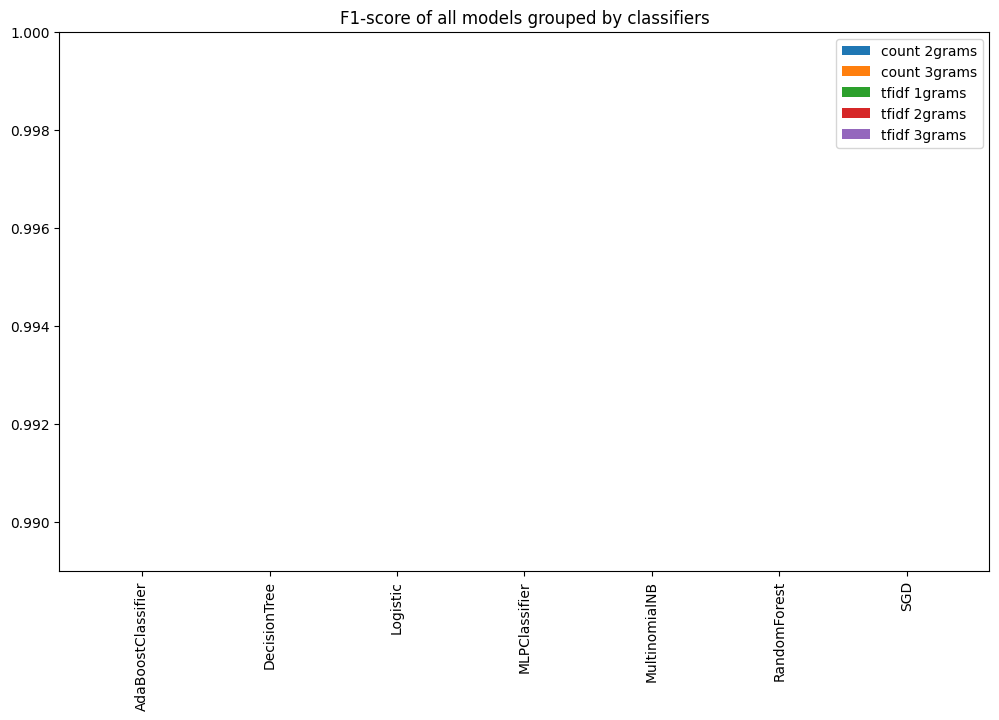

In [ ]:
def get_classifier_name(index):
    '''
    Returns the name of the classifier at the given index name
    '''
    return index.split()[len(index.split())-1]
    
#Group rows together using same classifier
grouped = classifier_results.groupby(get_classifier_name)

hist_df = pd.DataFrame(columns=['custom','count 1grams','count 2grams','count 3grams','tfidf 1grams','tfidf 2grams','tfidf 3grams'])

for classifier, indices in grouped.groups.items():
    
    #Make a list of feature spaces
    feature_spaces = indices.tolist()
    feature_spaces = [feature_space.replace(classifier,'') for feature_space in feature_spaces]
    feature_spaces = [feature_space.strip() for feature_space in feature_spaces]

    #If no result exists, it will stay as 0
    hist_df.loc[classifier] = {
            'custom':0,
            'count 1grams':0,
            'count 2grams':0,
            'count 3grams':0,
            'tfidf 1grams':0,
            'tfidf 2grams':0,
            'tfidf 3grams':0
    }
    
    #Extract F1-score from classifier_results to corrensponding entry in hist_df
    for fs in feature_spaces:
        hist_df[fs].loc[classifier] = classifier_results['F1-score'].loc[fs + ' ' + classifier]
        

#Plot the bar plot
f, ax = plt.subplots()
ax.set_ylim([0.989,1])
hist_df.plot(kind='bar', figsize=(12,7), title='F1-score of all models grouped by classifiers', ax=ax, width=0.8)


#Make Avgerage F1-score row and cols for the table and print the table
hist_df_nonzero = hist_df.copy()
hist_df_nonzero[hist_df > 0] = True
hist_df['Avg Feature'] = (hist_df.sum(axis=1) / np.array(hist_df_nonzero.sum(axis=1)))
hist_df_nonzero = hist_df.copy()
hist_df_nonzero[hist_df > 0] = True
hist_df.loc['Avg Classifier'] = (hist_df.sum(axis=0) / np.array(hist_df_nonzero.sum(axis=0)))
hist_df = hist_df.round(4)
display(hist_df)

In [ ]:
def plot_learning_curve(df_row,X,Y):
    '''Plots the learning curve of a classifier with its parameters
    
    input - df_row: row of classifier_result
            X: payload data
            Y: labels
    '''
    #The classifier to plot learning curve for
    estimator = df_row['model']
    
    title = 'Learning curves for classifier ' + df_row.name
    train_sizes = np.linspace(0.1,1.0,5)
    cv = ShuffleSplit(n=len(X), n_iter=3, test_size=0.2, random_state=0)
    
    #plot settings
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    print('learning curve in process...')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, n_jobs=-1, train_sizes=train_sizes, verbose=0) #Change verbose=10 to print progress
    print('Learning curve done!')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [ ]:
#plot learning curve for tfidf 1grams RandomForest
X = payloads['payload']
Y = payloads['injection_type']
plot_learning_curve(classifier_results.iloc[0],X,Y)

#plot learning curve for count 3grams MultinomialNB
X = payloads['payload']
Y = payloads['injection_type']
plot_learning_curve(classifier_results.iloc[6],X,Y)

#plot learning curve for custom svm
X = create_features2(pd.DataFrame(payloads['payload'].copy()))
Y = payloads['injection_type']
plot_learning_curve(classifier_results.iloc[5],X,Y)

TypeError: ignored

In [ ]:
def visualize_result(classifier_list):
    '''Plot the ROC curve for a list of classifiers in the same graph
    
    input - classifier_list: a subset of classifier_results
    '''

    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(15)
    
    #Subplot 1, ROC curve
    for classifier in classifier_list:
        ax1.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax1.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1.0])
    ax1.set_title('ROC curve for top3 and bottom3 classifiers')
    ax1.set_xlabel('False Positive Rate (1 - Specificity)')
    ax1.set_ylabel('True Positive Rate (Sensitivity)')
    ax1.grid(True)
    
    #subplot 2, ROC curve zoomed
    for classifier in classifier_list:
        ax2.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax2.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
    ax2.set_xlim([0, 0.3])
    ax2.set_ylim([0.85, 1.0])
    ax2.set_title('ROC curve for top3 and bottom3 classifiers (Zoomed)')
    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.grid(True)
    
    #Add further zoom
    left, bottom, width, height = [0.7, 0.27, 0.15, 0.15]
    ax3 = f.add_axes([left, bottom, width, height])
    
    for classifier in classifier_list:
        ax3.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax3.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
        
    ax3.set_xlim([0, 0.002])
    ax3.set_ylim([0.983, 1.0])
    ax3.set_title('Zoomed even further')
    ax3.grid(True)
    plt.show()

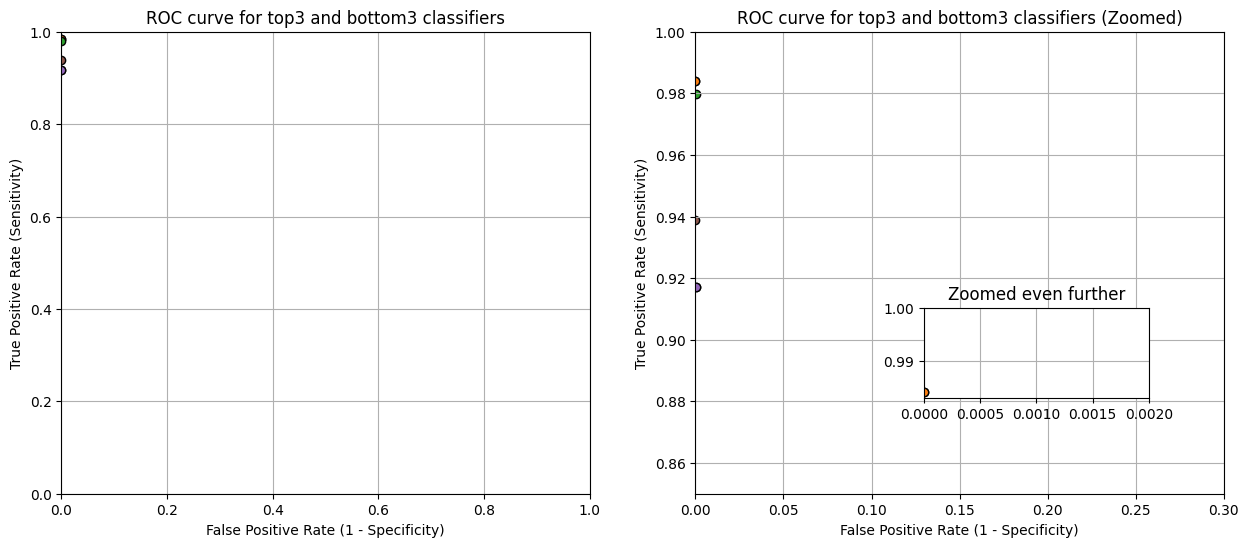

In [ ]:
indices = [0,1,2, len(classifier_results)-1,len(classifier_results)-2,len(classifier_results)-3]
visualize_result([classifier_results.iloc[index] for index in indices])

In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

def get2Grams(payload_obj):
    '''Divides a string into 2-grams
    
    Example: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

classifier = pickle.load( open("/content/drive/MyDrive/csv/pkl/tfidf_2grams_randomforest.p", "rb"))

def injection_test(inputs):
    variables = inputs.split('&')
    values = [ variable.split('=')[1] for variable in variables]
    print(values)
    return 'MALICIOUS' if classifier.predict(values).sum() > 0 else 'NOT_MALICIOUS'

In [ ]:
#test injection_test
display(injection_test("val1=%3Cscript%3Ekiddie"))

['%3Cscript%3Ekiddie']


'NOT_MALICIOUS'

In [ ]:
pipe = Pipeline([('vect', vectorizer), ('clf',LogisticRegression(C=10))])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv = ShuffleSplit(n=len(X_train), n_iter=1, test_size=0.2, random_state=0) #DEBUG: n_iter=10

random_grid_search = RandomizedSearchCV(
    pipe, 
    param_distributions={
        'clf__C':[10]
    },
    cv=cv, 
    scoring='roc_auc', 
    n_iter=1, 
    random_state=5,
    refit=True
)
random_grid_search.fit(X_train, Y_train)

#Evaluate the best model on the test data
Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)

NameError: ignored

In [ ]:
#Payloads classified incorrectly
pd.options.display.max_colwidth = 200
print('False positives')
print(X_test[(Y_test == 0) & (Y_test_predicted == 1)])
print('False negatives')
print(X_test[(Y_test == 1) & (Y_test_predicted == 0)])

False positives


NameError: ignored